# Machine learning project: Prediction race preformance from practice data

### Importing libraries 

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import svm

### For reproducibility

In [29]:
r_seed = np.random.seed(18) #My lucky number

### Collect data

In [30]:
data = pd.read_csv('F1_data.csv')

## Task 1: Classification

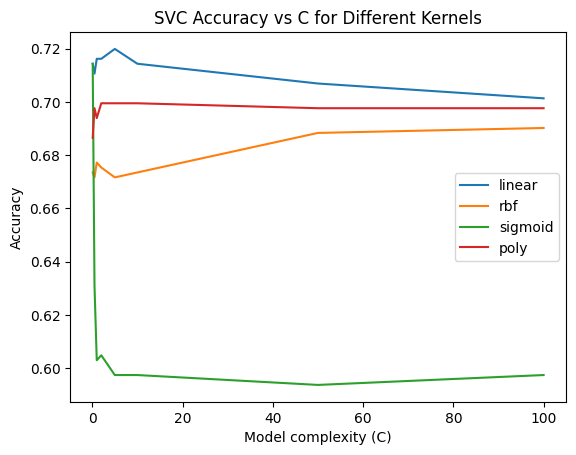

In [ ]:
#Remove all NaN values
data_classification = data.dropna(subset = ['FastestFPLap',
                                            'MeanFPLaps',
                                            'StdFPLaps',
                                            'DeltaBestFPLap',
                                            'FasterThanTeammateFP',
                                            'PointFinishRace'
                                            ])

#Input values
X = data_classification[['FastestFPLap'
                        ,'MeanFPLaps',
                        'StdFPLaps',
                        'DeltaBestFPLap',
                        'FasterThanTeammateFP',
                        ]]

#Target value
y = data_classification['PointFinishRace'].astype(int)

#Test / train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = r_seed)

#Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Test models with differnt kernels
kernels = ['linear', 'rbf', 'sigmoid', 'poly']
cs = [0.1, 0.5, 1, 2, 5, 10, 50, 100]
results = []

for kernel in kernels:
    for c in cs:
        model = svm.SVC(kernel = kernel, C = c)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results.append({'Kernel': kernel,
                        'C': c,
                        'Accuracy': accuracy
                        })

#Data frame for plotting
df_for_plotting = pd.DataFrame(results)

#Plot accuracy against complexity for each kernel
for kernel in df_for_plotting['Kernel'].unique():
    df = df_for_plotting[df_for_plotting['Kernel'] == kernel]
    plt.plot(df['C'], df['Accuracy'], label = kernel)

plt.legend()
plt.title('SVC Accuracy vs C for Different Kernels')
plt.ylabel('Accuracy')
plt.xlabel('Misclassification Penalty (C)')
plt.show()


In [32]:
# Find best result overall
best_row = df_for_plotting.loc[df_for_plotting['Accuracy'].idxmax()]
best_c = best_row['C']
best_acc = best_row['Accuracy']
best_kernel = best_row['Kernel']

print(f'Highest accuracy of {best_acc:.2f} with: Kernel = {best_kernel} and C = {best_c} ')

Highest accuracy of 0.72 with: Kernel = linear and C = 5.0 


In [44]:
#Training model with "best" values
model = svm.SVC(kernel = best_kernel, C = best_c)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"------------------- Kernel: {best_kernel} C = {best_c} -------------------")
print("Accuracy:", round(accuracy_score(y_test, y_pred),4))
print("Precision:", round(precision_score(y_test, y_pred),4))
print("Recall:", round(recall_score(y_test, y_pred),4))
print(classification_report(y_test, y_pred))

------------------- Kernel: linear C = 5.0 -------------------
Accuracy: 0.7199
Precision: 0.722
Recall: 0.703
              precision    recall  f1-score   support

           0       0.72      0.74      0.73       273
           1       0.72      0.70      0.71       266

    accuracy                           0.72       539
   macro avg       0.72      0.72      0.72       539
weighted avg       0.72      0.72      0.72       539



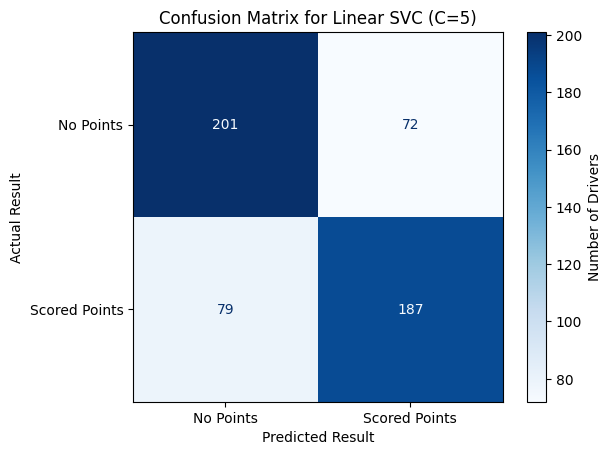

In [43]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Points", "Scored Points"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Linear SVC (C=5)")
plt.xlabel("Predicted Result")
plt.ylabel("Actual Result")
cbar = disp.ax_.images[-1].colorbar
cbar.set_label("Number of Drivers")
plt.show()

## Task 2: Bayesian and Probabilistic Modeling

Some text here

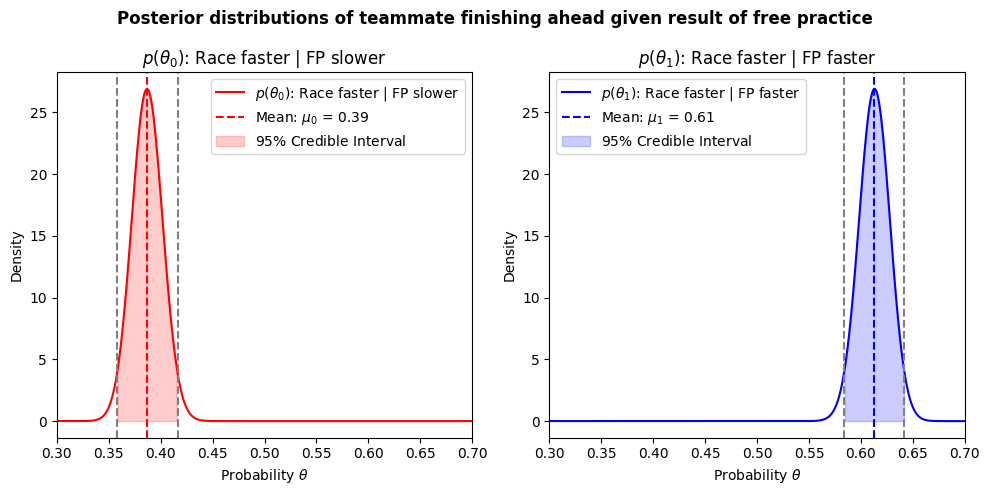

Prior: Beta(1, 1)
Prior mean: 0.50 (50.0%)

Race faster | FP faster
Posterior: Beta(662, 418)
Posterior mean: 0.61 (61.3%)

Race faster | FP slower
Posterior: Beta(418, 662)
Posterior mean: 0.39 (38.7%)


In [ ]:
# Columns
fp_col = "FasterThanTeammateFP"
race_col = "FasterThanTeammateRace"

# Drop NaN values
data = data[[fp_col, race_col]].dropna()

#Convert to int
fp = data[fp_col].astype(int)
race = data[race_col].astype(int)

#Prior belief
alpha_prior = 1
beta_prior  = 1
prior_mean  = alpha_prior / (alpha_prior + beta_prior)
theta = np.linspace(0, 1, 1000)
prior_pdf = stats.beta.pdf(theta, alpha_prior, beta_prior)

#Faster in race given faster in FP
idx_faster_fp = (fp == 1)
n_faster_in_race_fast_fp = race[idx_faster_fp].sum()
n_trails_faster_fp = fp.sum()

#Faster in race given slower in FP
idx_slower_fp = (fp == 0)
n_faster_in_race_slower_fp = race[idx_slower_fp].sum()
n_trails_slower_fp = fp.sum()

def beta_post(success, n_trails, alpha_prior, beta_prior, n_theta = 1000):
    alpha_post = alpha_prior + success
    beta_post = beta_prior + (n_trails - success)
    post_mean = alpha_post / (alpha_post + beta_post)

    ci_lower = stats.beta.ppf(0.025, alpha_post, beta_post)
    ci_upper = stats.beta.ppf(0.975, alpha_post, beta_post)

    theta = np.linspace(0, 1, n_theta)
    post_pdf = stats.beta.pdf(theta, alpha_post, beta_post)

    return ci_lower, ci_upper, post_pdf, alpha_post, beta_post, post_mean

# Grid for θ
theta = np.linspace(0, 1, 1000)

#Plotting
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
ci_l_0, ci_u_0, pdf0, alpha_p_0, beta_p_0, post_m_0 = beta_post(n_faster_in_race_slower_fp,
                                                                n_trails_slower_fp, alpha_prior,
                                                                beta_prior)
plt.plot(theta, pdf0, '-',label = r'$p(\theta_0)$: Race faster | FP slower', color = 'red')
plt.axvline(post_m_0, color='red', linestyle='--', label=rf'Mean: $\mu_0$ = {post_m_0:.2f}')
plt.axvline(ci_l_0, linestyle = '--', color = 'grey')
plt.axvline(ci_u_0, linestyle = '--', color = 'grey')
plt.fill_between(theta, pdf0, where=(theta >= ci_l_0) & (theta <= ci_u_0), alpha=0.2, color = 'red', label=r'$95\% \text{ Credible Interval}$')
plt.xlim([0.3, 0.7])
plt.xlabel(r'Probability $\theta$')
plt.ylabel('Density')
plt.title(r'$p(\theta_0)$: Race faster | FP slower')
plt.legend()

plt.subplot(1, 2, 2)
ci_l_1, ci_i_1, pdf1, alpha_p_1, beta_p_1, post_m_1 = beta_post(n_faster_in_race_fast_fp,
                                                                n_trails_faster_fp, alpha_prior,
                                                                beta_prior)
plt.plot(theta, pdf1, '-',label = r'$p(\theta_1)$: Race faster | FP faster', color = 'blue')
plt.axvline(post_m_1, color='blue', linestyle='--', label=rf'Mean: $\mu_1$ = {post_m_1:.2f}')
plt.axvline(ci_l_1, linestyle = '--', color = 'grey')
plt.axvline(ci_i_1, linestyle = '--', color = 'grey')
plt.fill_between(theta, pdf1, where=(theta >= ci_l_1) & (theta <= ci_i_1), alpha=0.2, color = 'blue', label=r'$95\% \text{ Credible Interval}$')
plt.xlim([0.3, 0.7])
plt.xlabel(r'Probability $\theta$')
plt.ylabel('Density')
plt.title(r'$p(\theta_1)$: Race faster | FP faster')
plt.legend()

plt.suptitle('Posterior distributions of teammate finishing ahead given result of free practice', fontweight='bold')
plt.tight_layout()
plt.show()

#Prior belief
print(f'Prior: Beta({alpha_prior}, {beta_prior})')
print(f'Prior mean: {prior_mean:.2f} ({prior_mean*100:.1f}%)')

#Posterior belief
print('\nRace faster | FP faster')
print(f'Posterior: Beta({alpha_p_1}, {beta_p_1})')
print(f'Posterior mean: {post_m_1:.2f} ({post_m_1*100:.1f}%)')

print('\nRace faster | FP slower')
print(f'Posterior: Beta({alpha_p_0}, {beta_p_0})')
print(f'Posterior mean: {post_m_0:.2f} ({post_m_0*100:.1f}%)')
